In [1]:
import tensorflow as tf
import numpy as np
import os
import PIL
import PIL.Image
import pathlib
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.9.2


In [3]:
batch_size = 32
img_height = 180
img_width = 180
data_dir = "./train/"

In [5]:
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

58393


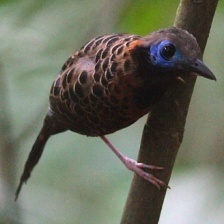

In [7]:
antbird = list(data_dir.glob('ANTBIRD/*.jpg'))
PIL.Image.open(str(antbird[0]))

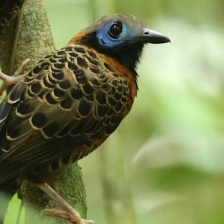

In [8]:
PIL.Image.open(str(antbird[1]))

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 58393 files belonging to 400 classes.
Using 46715 files for training.
Metal device set to: Apple M1 Max


2022-07-26 16:44:22.069709: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-26 16:44:22.069862: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
class_names = train_ds.class_names

In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 58393 files belonging to 400 classes.
Using 11678 files for validation.


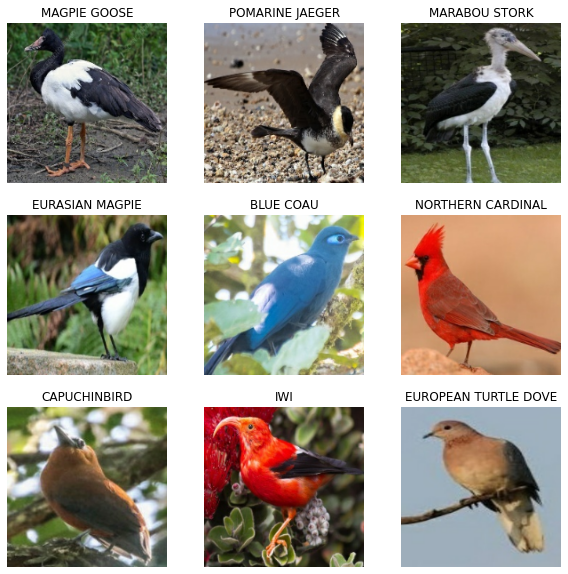

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [19]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

2022-07-26 17:04:56.563196: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


0.0 1.0


In [21]:
from tensorflow.keras import layers

In [26]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [27]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [28]:
model.build()

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [30]:
epochs=10
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10


2022-07-26 17:19:07.103262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1460/1460 [==============================] - ETA: 0s - loss: 4.9802 - accuracy: 0.0731

2022-07-26 17:19:44.960748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1460/1460 [==============================] - 42s 26ms/step - loss: 4.9802 - accuracy: 0.0731 - val_loss: 4.0152 - val_accuracy: 0.1838
Epoch 2/10
1460/1460 [==============================] - 37s 26ms/step - loss: 3.2535 - accuracy: 0.3031 - val_loss: 3.0257 - val_accuracy: 0.3525
Epoch 3/10
1460/1460 [==============================] - 37s 25ms/step - loss: 2.2986 - accuracy: 0.4735 - val_loss: 2.8140 - val_accuracy: 0.3943
Epoch 4/10
1460/1460 [==============================] - 37s 26ms/step - loss: 1.6486 - accuracy: 0.6015 - val_loss: 2.8542 - val_accuracy: 0.4098
Epoch 5/10
1460/1460 [==============================] - 37s 25ms/step - loss: 1.1337 - accuracy: 0.7123 - val_loss: 3.1814 - val_accuracy: 0.4012
Epoch 6/10
1460/1460 [==============================] - 37s 25ms/step - loss: 0.7136 - accuracy: 0.8096 - val_loss: 3.7709 - val_accuracy: 0.3937
Epoch 7/10
1460/1460 [==============================] - 37s 26ms/step - loss: 0.4529 - accuracy: 0.8719 - val_loss: 4.5086 - val_accura

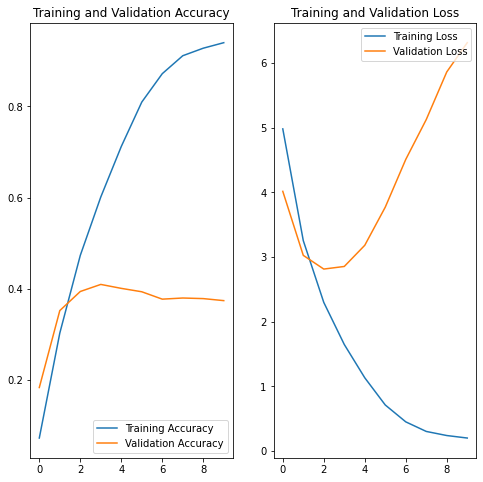

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential(
      [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                      img_width,
                                      3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
      ]
    )

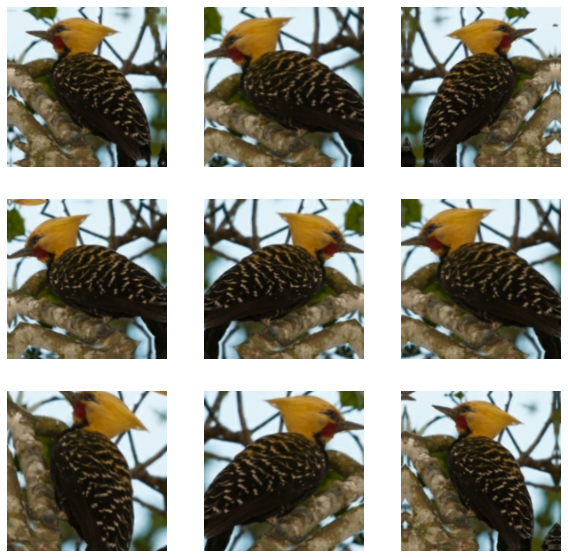

In [42]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [44]:
model = tf.keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [45]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [46]:
model.build()

In [47]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [48]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


2022-07-26 17:36:28.976101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1460/1460 [==============================] - ETA: 0s - loss: 5.0959 - accuracy: 0.0533

2022-07-26 17:38:55.162424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1460/1460 [==============================] - 150s 102ms/step - loss: 5.0959 - accuracy: 0.0533 - val_loss: 4.1677 - val_accuracy: 0.1481
Epoch 2/15
1460/1460 [==============================] - 151s 104ms/step - loss: 3.7077 - accuracy: 0.2102 - val_loss: 3.3604 - val_accuracy: 0.2776
Epoch 3/15
1460/1460 [==============================] - 154s 106ms/step - loss: 3.0327 - accuracy: 0.3252 - val_loss: 3.0326 - val_accuracy: 0.3549
Epoch 4/15
1460/1460 [==============================] - 160s 109ms/step - loss: 2.6521 - accuracy: 0.3951 - val_loss: 2.9138 - val_accuracy: 0.3794
Epoch 5/15
1460/1460 [==============================] - 166s 114ms/step - loss: 2.4058 - accuracy: 0.4405 - val_loss: 2.6683 - val_accuracy: 0.4212
Epoch 6/15
1460/1460 [==============================] - 167s 115ms/step - loss: 2.2069 - accuracy: 0.4822 - val_loss: 2.7038 - val_accuracy: 0.4236
Epoch 7/15
1460/1460 [==============================] - 169s 116ms/step - loss: 2.0748 - accuracy: 0.5103 - val_loss: 2.488

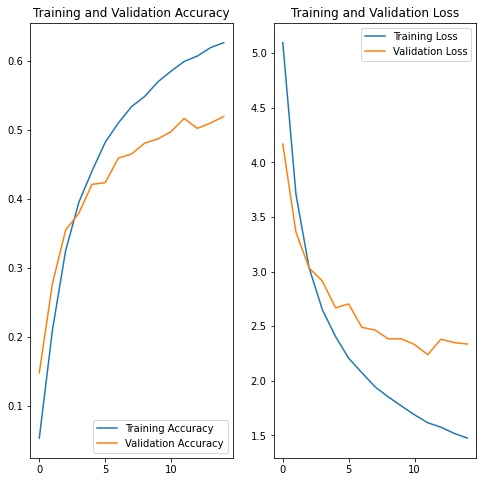

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [55]:
ant_bird_path = "./images to test/7.jpg"

img = tf.keras.utils.load_img(
    ant_bird_path, target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 15ms/step
This image most likely belongs to ANTBIRD with a 99.01 percent confidence.


In [58]:
model.save("saved_model/bird_classification")

INFO:tensorflow:Assets written to: saved_model/bird_classification/assets


INFO:tensorflow:Assets written to: saved_model/bird_classification/assets
